## 1. Imports and Configuration

In [17]:
import sys
from pathlib import Path
from datetime import datetime, timedelta

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from loguru import logger

# Add root directory to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Import Open-Meteo Forecast synchronous adapter
from scripts.api.services.openmeteo_forecast.openmeteo_forecast_sync_adapter import OpenMeteoForecastSyncAdapter

# Configure logging
logger.remove()
logger.add(sys.stdout, level="INFO")

# Configure plot style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Imports completed")

Imports completed


## 2. Initialize Open-Meteo Forecast Client

In [18]:
# Create synchronous adapter (with local cache)
forecast_adapter = OpenMeteoForecastSyncAdapter(cache_dir=".cache")

# Check API information
info = forecast_adapter.get_info()
print("\nOpen-Meteo Forecast API Information:")
for key, value in info.items():
    print(f"  {key}: {value}")

2025-11-27 18:02:50.954 | INFO     | scripts.api.services.openmeteo_forecast.openmeteo_forecast_sync_adapter:__init__:65 - OpenMeteoForecastSyncAdapter initialized (Local cache, -25d to +5d = 30d total)

Open-Meteo Forecast API Information:
  api: Open-Meteo Forecast
  url: https://api.open-meteo.com/v1/forecast
  coverage: Global
  period: 2025-08-27 to 2025-12-13
  resolution: Daily
  license: CC BY 4.0
  attribution: Weather data by Open-Meteo.com (CC BY 4.0)
  cache_ttl: 6 hours

Open-Meteo Forecast API Information:
  api: Open-Meteo Forecast
  url: https://api.open-meteo.com/v1/forecast
  coverage: Global
  period: 2025-08-27 to 2025-12-13
  resolution: Daily
  license: CC BY 4.0
  attribution: Weather data by Open-Meteo.com (CC BY 4.0)
  cache_ttl: 6 hours


## 3. Download Real Data - São Paulo/SP

Let's download recent climate data + forecast for **São Paulo/SP**.

**Coordinates**: -23.5505°S, -46.6333°W  
**Period**: Last 15 days + next 5 days = 20 days total

In [19]:
# Define location: São Paulo/SP
lat = -23.5505
lon = -46.6333
location_name = "São Paulo/SP"

# Define period: last 15 days + next 5 days
start_date = datetime.now() - timedelta(days=15)
end_date = datetime.now() + timedelta(days=5)

print(f"Location: {location_name}")
print(f"Period: {start_date.date()} to {end_date.date()}")
print(f"Coordinates: {lat:.4f}°, {lon:.4f}°")
print(f"Includes recent data + 5-day forecast")

Location: São Paulo/SP
Period: 2025-11-12 to 2025-12-02
Coordinates: -23.5505°, -46.6333°
Includes recent data + 5-day forecast


In [20]:
# Download data
print("\nDownloading data from Open-Meteo Forecast...\n")

forecast_data = forecast_adapter.get_daily_data_sync(
    lat=lat,
    lon=lon,
    start_date=start_date,
    end_date=end_date
)

print(f"\nData downloaded: {len(forecast_data)} records")



2025-11-27 18:02:50.976 | INFO     | scripts.api.services.openmeteo_forecast.openmeteo_forecast_client:__init__:107 - OpenMeteoForecastClient initialized (Local cache, -30d to +5d)
2025-11-27 18:02:50.978 | INFO     | scripts.api.services.openmeteo_forecast.openmeteo_forecast_client:get_climate_data:227 - Cache MISS: Forecast API | (-23.5505, -46.6333)
2025-11-27 18:02:50.978 | INFO     | scripts.api.services.openmeteo_forecast.openmeteo_forecast_client:get_climate_data:228 - Requested period: 2025-11-12 to 2025-12-02
2025-11-27 18:02:50.979 | INFO     | scripts.api.services.openmeteo_forecast.openmeteo_forecast_client:get_climate_data:229 - Calculated: past_days=15, forecast_days=5
2025-11-27 18:02:50.979 | INFO     | scripts.api.services.openmeteo_forecast.openmeteo_forecast_client:get_climate_data:233 - API params: {'latitude': -23.5505, 'longitude': -46.6333, 'daily': ['temperature_2m_max', 'temperature_2m_mean', 'temperature_2m_min', 'relative_humidity_2m_max', 'relative_humidit

## 4. Convert to DataFrame and Explore

In [21]:
# Convert to DataFrame
df = pd.DataFrame(forecast_data)

# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

# Add flag to identify forecast vs recent data
today = pd.Timestamp.now().normalize()
df['is_forecast'] = df['date'] > today

# Display first rows
print("\nFirst 5 rows of data:")
display(df.head())

# Count recent vs forecast data
recent_count = (~df['is_forecast']).sum()
forecast_count = df['is_forecast'].sum()
print(f"\nRecent data: {recent_count} | Forecast: {forecast_count}")


First 5 rows of data:


,date,temperature_2m_max,temperature_2m_mean,temperature_2m_min,relative_humidity_2m_max,relative_humidity_2m_mean,relative_humidity_2m_min,wind_speed_10m_mean,shortwave_radiation_sum,precipitation_sum,et0_fao_evapotranspiration,wind_speed_2m_mean,is_forecast
0,2025-11-12,30.428501,21.472248,14.578500,94.0,68.375,33.0,1.236350,28.790001,0.0,5.894825,0.924729,False
1,2025-11-13,29.678501,22.459751,18.228500,94.0,72.625,38.0,1.225913,18.110001,5.2,4.041422,0.916923,False
2,2025-11-14,24.178501,20.409750,17.978500,85.0,74.000,60.0,2.438940,19.240000,0.0,3.870599,1.824208,False
3,2025-11-15,25.078501,20.509750,17.428501,90.0,78.875,59.0,2.090272,17.770000,0.0,3.607065,1.563421,False
4,2025-11-16,25.628500,22.116001,19.478500,95.0,80.500,63.0,2.008169,12.460000,3.0,2.883357,1.502012,False



Recent data: 16 | Forecast: 4


In [22]:
# Descriptive statistics
print("\nDescriptive Statistics:")
display(df.describe())


Descriptive Statistics:


,date,temperature_2m_max,temperature_2m_mean,temperature_2m_min,relative_humidity_2m_max,relative_humidity_2m_mean,relative_humidity_2m_min,wind_speed_10m_mean,shortwave_radiation_sum,precipitation_sum,et0_fao_evapotranspiration,wind_speed_2m_mean
count,20,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,2025-11-21 12:00:00,27.316000,21.589438,17.346000,89.600000,71.156250,45.900000,2.028753,23.000000,2.135000,4.755748,1.517408
min,2025-11-12 00:00:00,23.378500,18.759748,13.928500,76.000000,56.500000,23.000000,1.197327,12.370000,0.000000,2.553459,0.895542
25%,2025-11-16 18:00:00,24.478501,19.844126,15.753500,88.000000,67.593750,32.500000,1.567836,17.205000,0.000000,3.504666,1.172665
50%,2025-11-21 12:00:00,25.678500,21.622249,17.428501,90.500000,70.625000,45.000000,1.991416,24.629999,0.000000,5.045621,1.489482
75%,2025-11-26 06:00:00,30.466001,22.650376,18.653502,93.000000,78.125000,59.250000,2.489947,30.012500,1.075000,5.900919,1.862358
max,2025-12-01 00:00:00,34.928497,27.072250,21.128500,95.000000,84.750000,68.000000,3.035232,31.799999,23.800001,6.937334,2.270205
std,NaN,3.559785,2.249740,2.023564,4.523622,7.921269,14.326641,0.571858,7.124313,5.436454,1.410374,0.427722


## 5. Visualizations

### 5.1 Temperatures (with forecast highlighted)

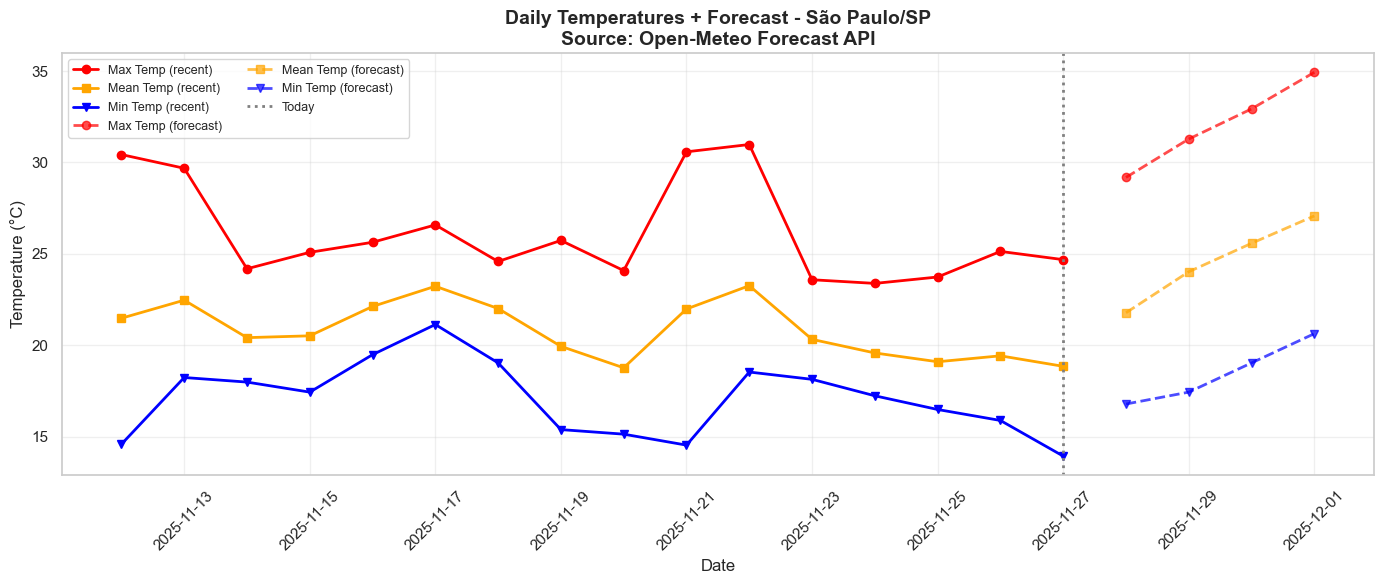

In [23]:
fig, ax = plt.subplots(figsize=(14, 6))

# Separate recent and forecast data
df_recent = df[~df['is_forecast']]
df_forecast = df[df['is_forecast']]

# Recent data (solid lines)
ax.plot(df_recent['date'], df_recent['temperature_2m_max'], label='Max Temp (recent)', 
        color='red', linewidth=2, marker='o', linestyle='-')
ax.plot(df_recent['date'], df_recent['temperature_2m_mean'], label='Mean Temp (recent)', 
        color='orange', linewidth=2, marker='s', linestyle='-')
ax.plot(df_recent['date'], df_recent['temperature_2m_min'], label='Min Temp (recent)', 
        color='blue', linewidth=2, marker='v', linestyle='-')

# Forecast (dashed lines)
ax.plot(df_forecast['date'], df_forecast['temperature_2m_max'], label='Max Temp (forecast)', 
        color='red', linewidth=2, marker='o', linestyle='--', alpha=0.7)
ax.plot(df_forecast['date'], df_forecast['temperature_2m_mean'], label='Mean Temp (forecast)', 
        color='orange', linewidth=2, marker='s', linestyle='--', alpha=0.7)
ax.plot(df_forecast['date'], df_forecast['temperature_2m_min'], label='Min Temp (forecast)', 
        color='blue', linewidth=2, marker='v', linestyle='--', alpha=0.7)

# Vertical line separating recent from forecast
ax.axvline(x=today, color='gray', linestyle=':', linewidth=2, label='Today')

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Temperature (°C)', fontsize=12)
ax.set_title(f'Daily Temperatures + Forecast - {location_name}\nSource: Open-Meteo Forecast API', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=9, ncol=2)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 5.2 Precipitation (recent + forecast)

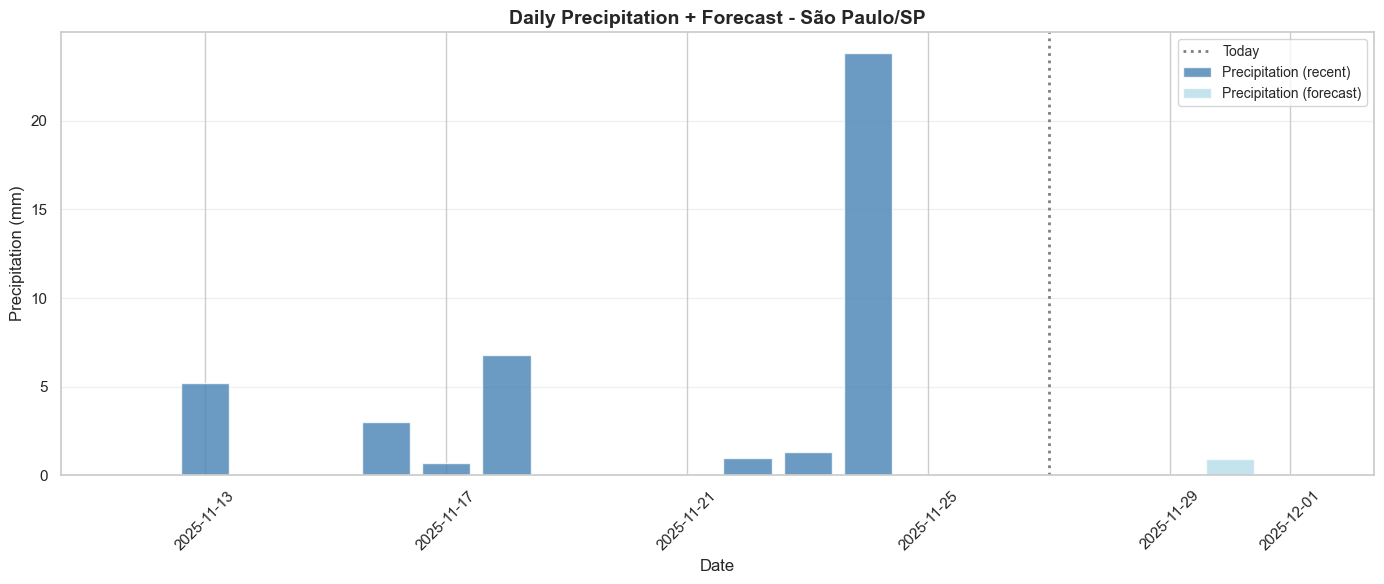

In [24]:
fig, ax = plt.subplots(figsize=(14, 6))

# Recent data (solid blue)
ax.bar(df_recent['date'], df_recent['precipitation_sum'], 
       color='steelblue', alpha=0.8, label='Precipitation (recent)')

# Forecast (light blue)
ax.bar(df_forecast['date'], df_forecast['precipitation_sum'], 
       color='lightblue', alpha=0.7, label='Precipitation (forecast)')

# Vertical line separating recent from forecast
ax.axvline(x=today, color='gray', linestyle=':', linewidth=2, label='Today')

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Precipitation (mm)', fontsize=12)
ax.set_title(f'Daily Precipitation + Forecast - {location_name}', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 5.3 ET0 (Reference Evapotranspiration)

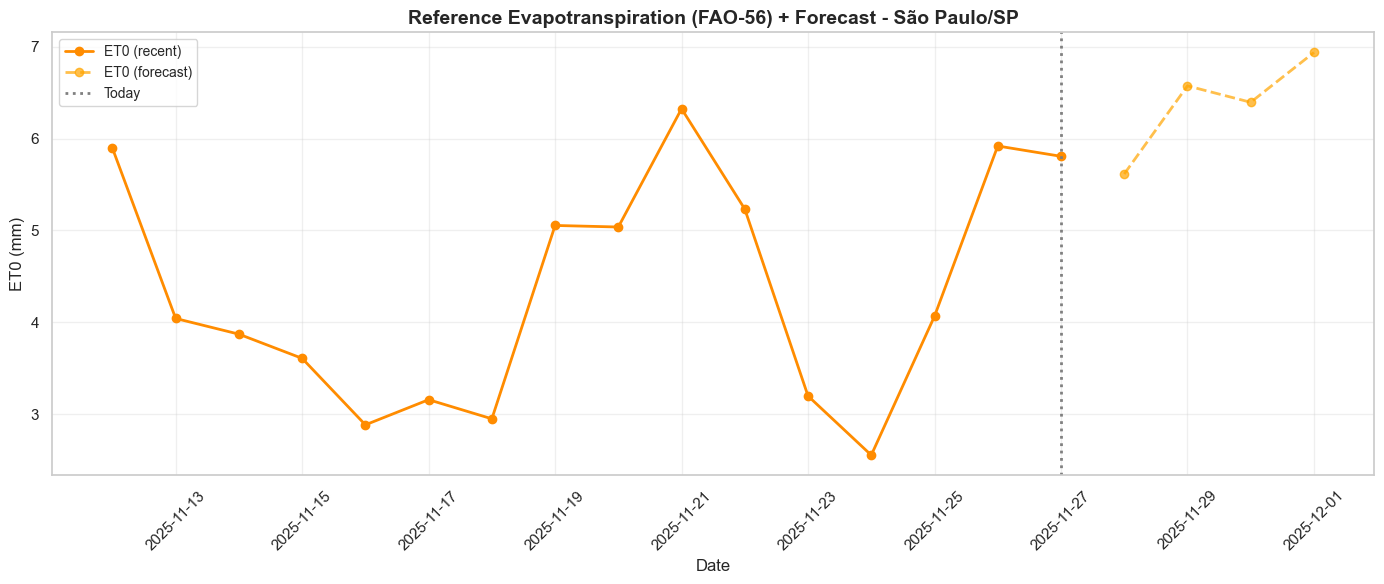

In [25]:
fig, ax = plt.subplots(figsize=(14, 6))

# Recent data (solid line)
ax.plot(df_recent['date'], df_recent['et0_fao_evapotranspiration'], 
        color='darkorange', linewidth=2, marker='o', linestyle='-', label='ET0 (recent)')

# Forecast (dashed line)
ax.plot(df_forecast['date'], df_forecast['et0_fao_evapotranspiration'], 
        color='orange', linewidth=2, marker='o', linestyle='--', alpha=0.7, label='ET0 (forecast)')

# Vertical line separating recent from forecast
ax.axvline(x=today, color='gray', linestyle=':', linewidth=2, label='Today')

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('ET0 (mm)', fontsize=12)
ax.set_title(f'Reference Evapotranspiration (FAO-56) + Forecast - {location_name}', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 5.4 Relative Humidity and Wind Speed

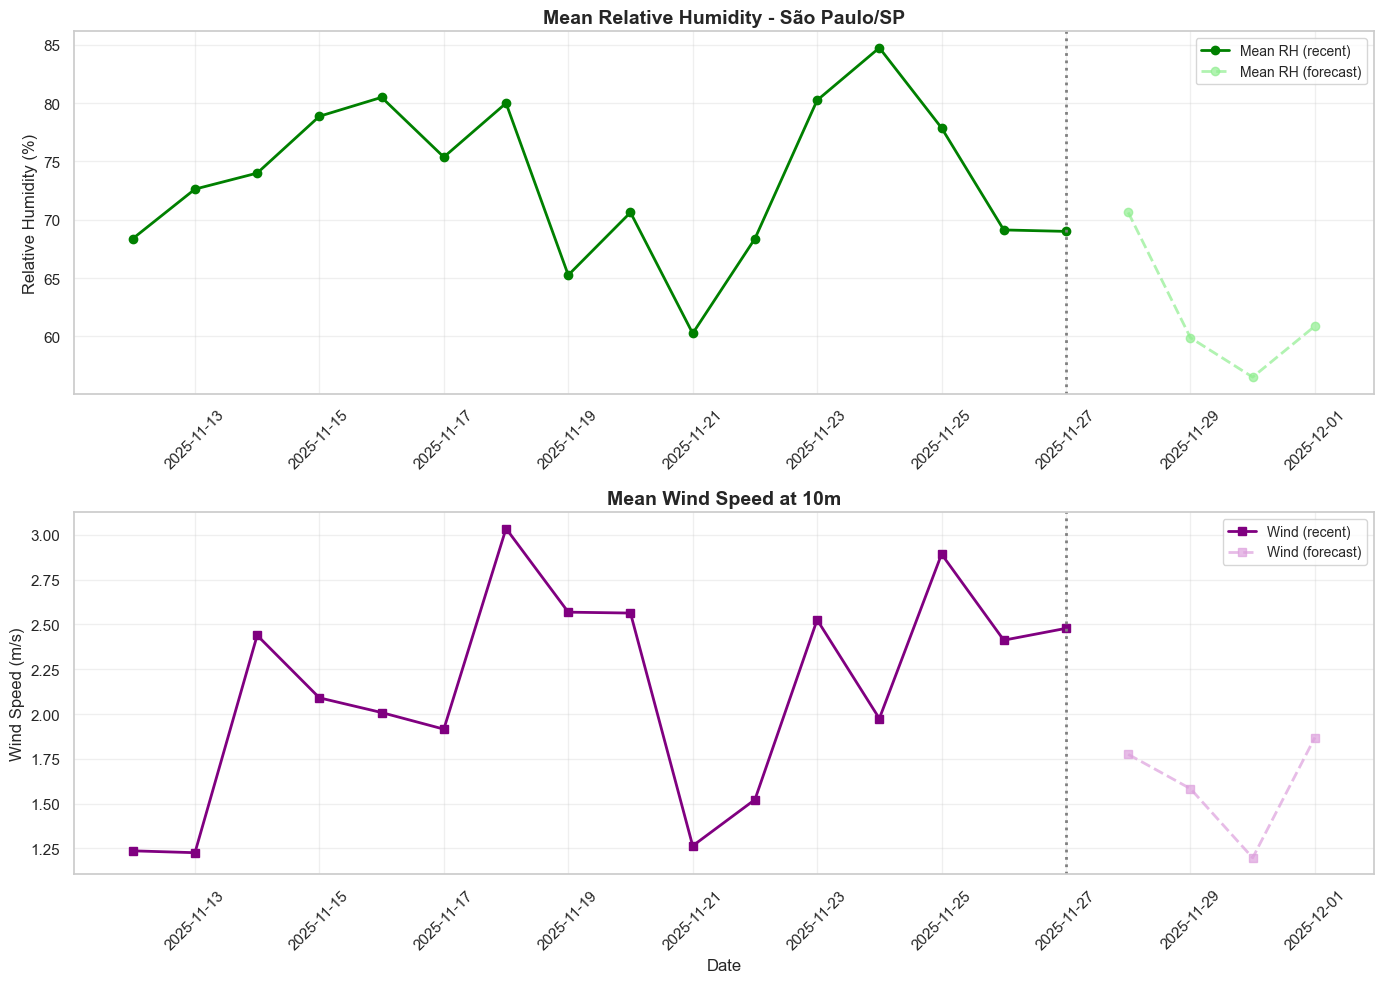

In [26]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Relative Humidity
ax1.plot(df_recent['date'], df_recent['relative_humidity_2m_mean'], 
         color='green', linewidth=2, marker='o', linestyle='-', label='Mean RH (recent)')
ax1.plot(df_forecast['date'], df_forecast['relative_humidity_2m_mean'], 
         color='lightgreen', linewidth=2, marker='o', linestyle='--', alpha=0.7, label='Mean RH (forecast)')
ax1.axvline(x=today, color='gray', linestyle=':', linewidth=2)
ax1.set_ylabel('Relative Humidity (%)', fontsize=12)
ax1.set_title(f'Mean Relative Humidity - {location_name}', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Wind Speed
ax2.plot(df_recent['date'], df_recent['wind_speed_10m_mean'], 
         color='purple', linewidth=2, marker='s', linestyle='-', label='Wind (recent)')
ax2.plot(df_forecast['date'], df_forecast['wind_speed_10m_mean'], 
         color='plum', linewidth=2, marker='s', linestyle='--', alpha=0.7, label='Wind (forecast)')
ax2.axvline(x=today, color='gray', linestyle=':', linewidth=2)
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Wind Speed (m/s)', fontsize=12)
ax2.set_title('Mean Wind Speed at 10m', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
plt.tight_layout()
plt.show()

## 6. Health Check

In [27]:
# Check API availability
is_healthy = forecast_adapter.health_check_sync()

if is_healthy:
    print("Open-Meteo Forecast API is working correctly")
else:
    print("Open-Meteo Forecast API is not accessible")

2025-11-27 18:02:52.095 | INFO     | scripts.api.services.openmeteo_forecast.openmeteo_forecast_client:__init__:107 - OpenMeteoForecastClient initialized (Local cache, -30d to +5d)
2025-11-27 18:02:52.097 | INFO     | scripts.api.services.openmeteo_forecast.openmeteo_forecast_client:get_climate_data:227 - Cache MISS: Forecast API | (-15.7939, -47.8828)
2025-11-27 18:02:52.098 | INFO     | scripts.api.services.openmeteo_forecast.openmeteo_forecast_client:get_climate_data:228 - Requested period: 2025-11-27 to 2025-11-27
2025-11-27 18:02:52.098 | INFO     | scripts.api.services.openmeteo_forecast.openmeteo_forecast_client:get_climate_data:229 - Calculated: past_days=0, forecast_days=0
2025-11-27 18:02:52.098 | INFO     | scripts.api.services.openmeteo_forecast.openmeteo_forecast_client:get_climate_data:233 - API params: {'latitude': -15.7939, 'longitude': -47.8828, 'daily': ['temperature_2m_max', 'temperature_2m_mean', 'temperature_2m_min', 'relative_humidity_2m_max', 'relative_humidity_2

## 7. Save Data

In [28]:
# Save DataFrame as CSV
output_file = project_root / "data" / "csv" / "openmeteo_forecast_saopaulo_demo.csv"
output_file.parent.mkdir(parents=True, exist_ok=True)

df.to_csv(output_file, index=False)
print(f"\nData saved to: {output_file}")
print(f"Total records: {len(df)}")
print(f"Recent data: {recent_count} | Forecast: {forecast_count}")


Data saved to: c:\Users\User\OneDrive\Documentos\GitHub\EVAONLINE\EVAonline_validation_v1.0.0\data\csv\openmeteo_forecast_saopaulo_demo.csv
Total records: 20
Recent data: 16 | Forecast: 4


---

## References

**Open-Meteo Forecast API**
- Website: https://open-meteo.com/
- API Documentation: https://open-meteo.com/en/docs
- Citation: Zippenfenig, P. (2023). Open-Meteo.com Weather API [Computer software]. Zenodo. https://doi.org/10.5281/zenodo.14582479

**License**: CC BY 4.0 (attribution required)

---